In [12]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images
from utils.Preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from utils.logger import save_full_report
from trainer import trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training

In [2]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.9,
    "epcohs":30,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "output_base_path" : "./outputs",
    "name" : "Attention7-512caped"
}
class_map = {
    0: '1',1: '2', 2: '3',3: '4',
    4: '5',5: '6',6: '7',7: '8',
    8: '9',9: '9a',10: '10',11: '10a',
    12: '11',13: '12',14: '12a',15: '13',
    16: '14',17: '14a',18: '15',19: '16',
    20: '16a',21: '16b',22: '16c',
    23: '12b',24: '14b'
}

In [ ]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 25),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()
])
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()
])
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [ ]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

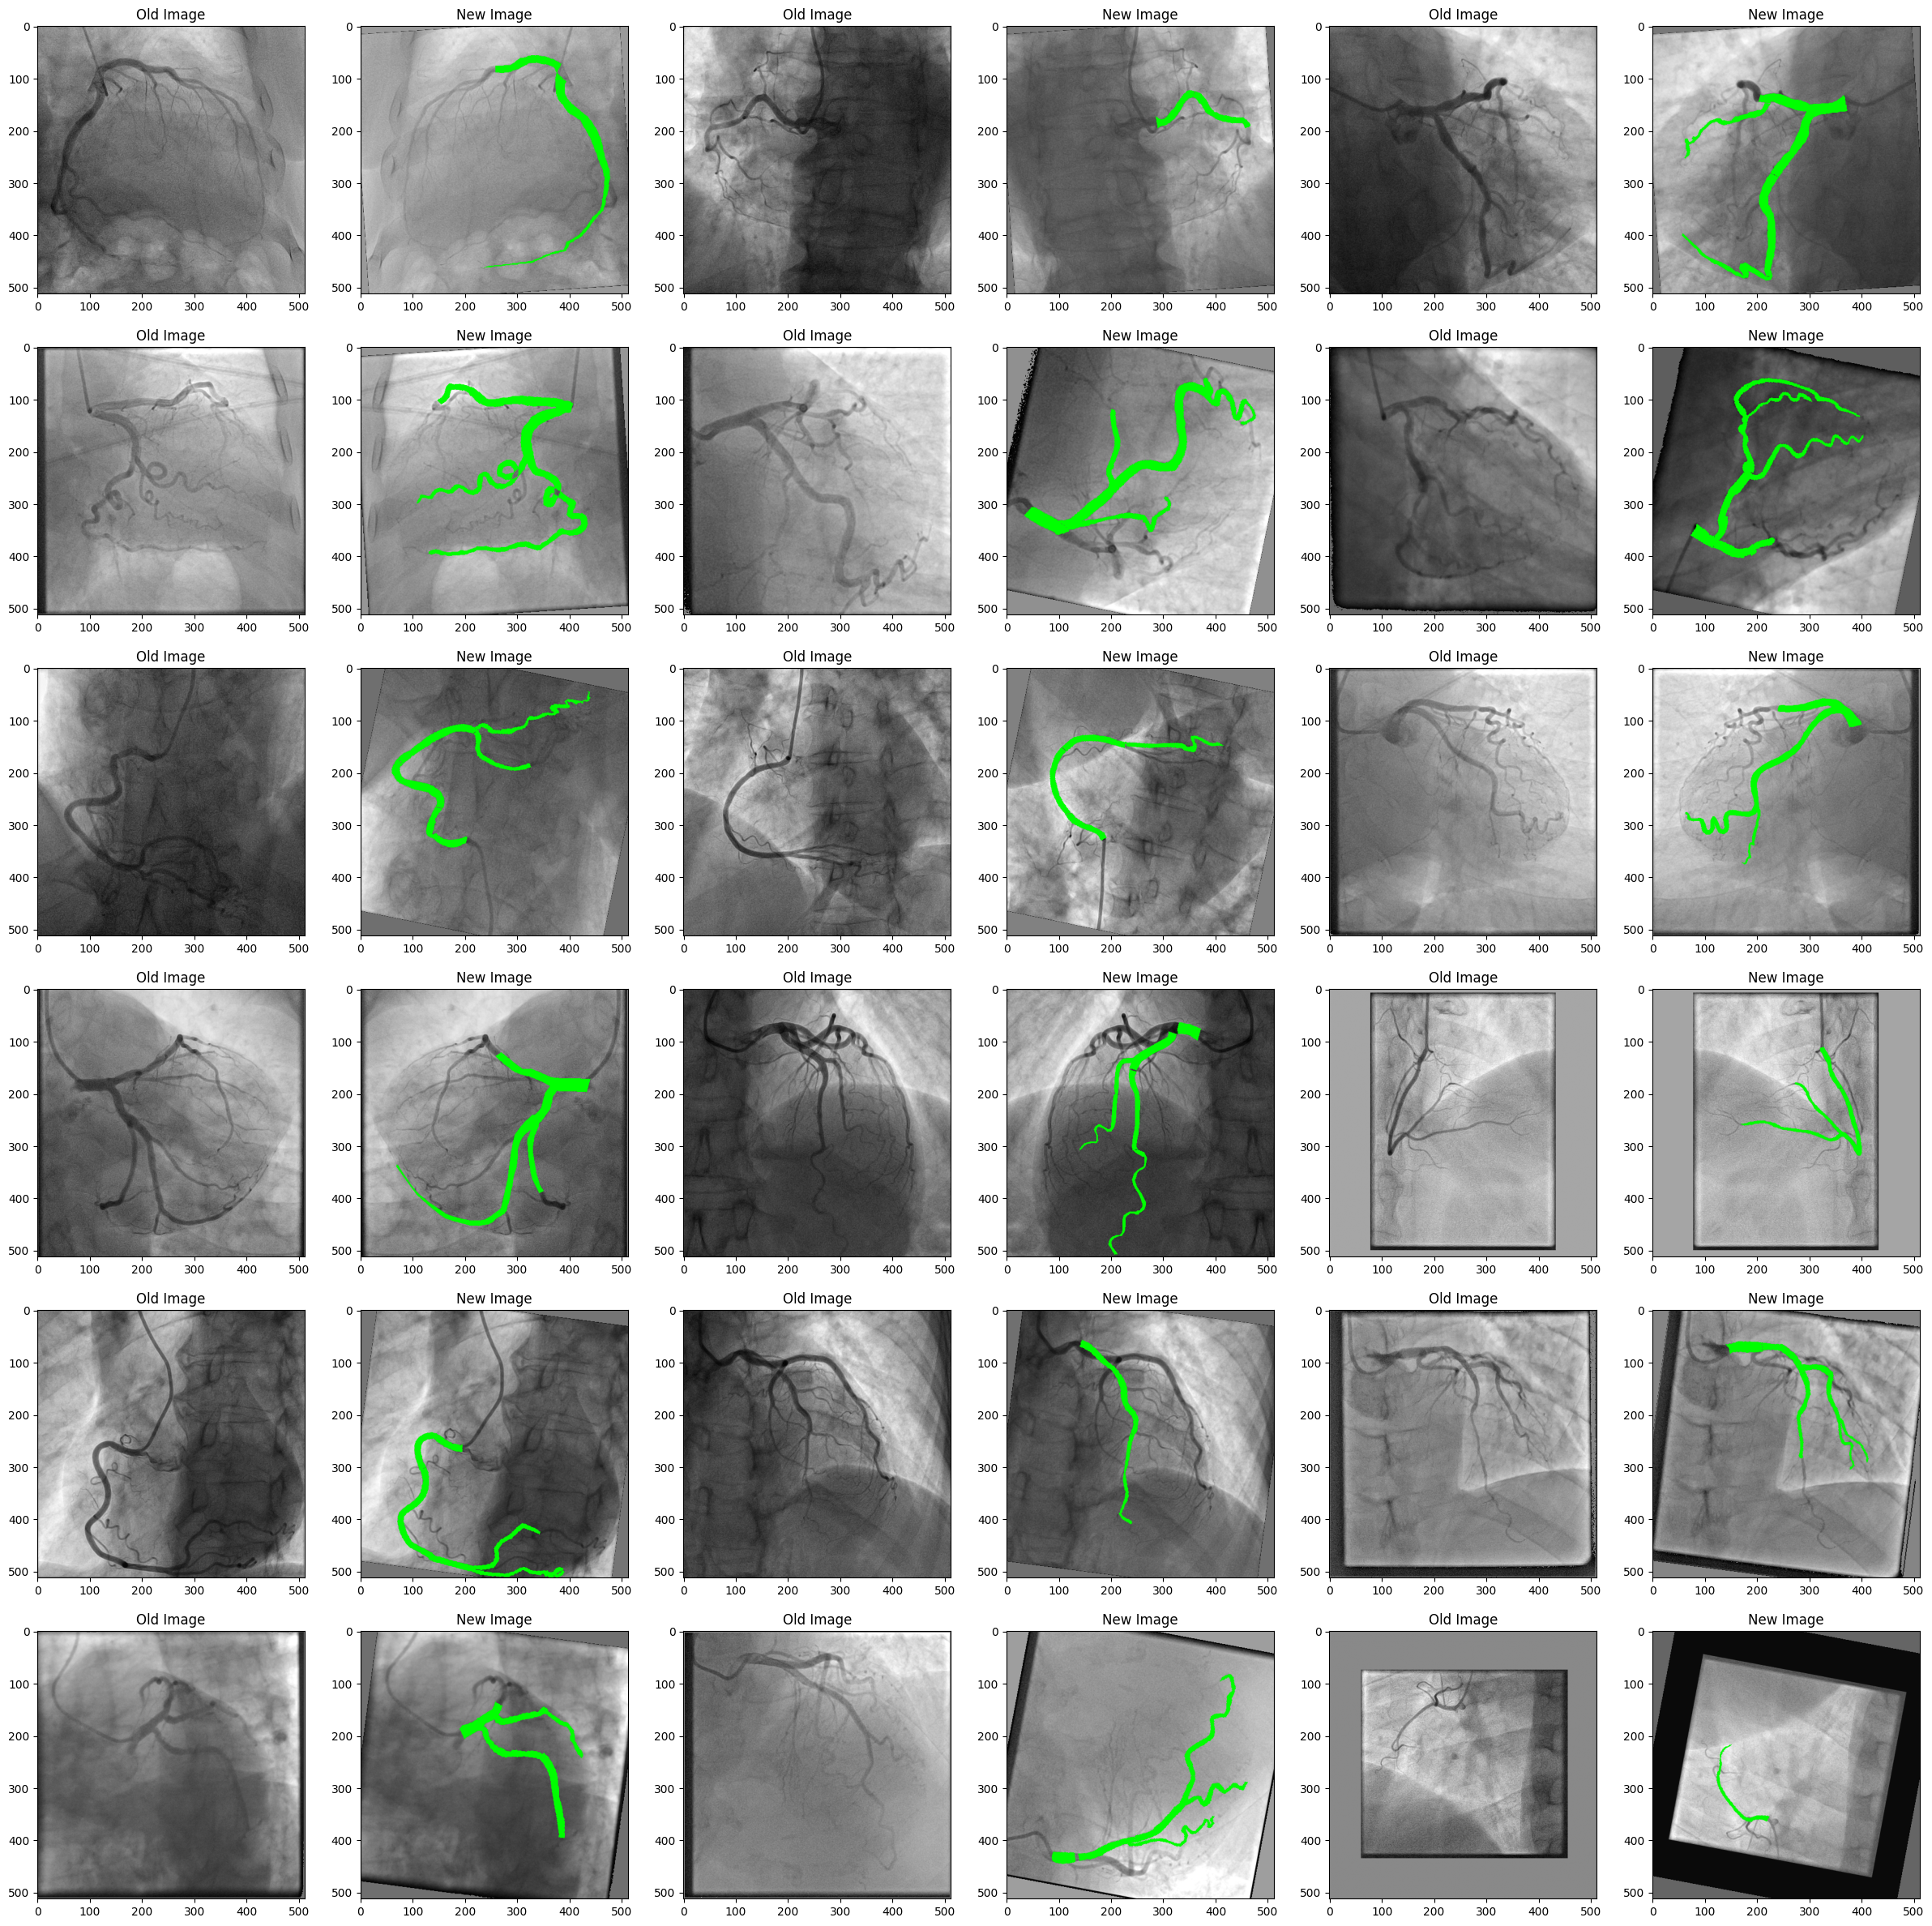

In [ ]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [4]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
recorder = HistoryRecorder(class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0) | loss : 1.6677624440193177 
dice loss : -0.01158169132657349 - bce loss : 1.6793441325426102 
train avg dice epoch 0 : 0.0026312466441011633
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0) | loss : 0.6884654015302658 
dice loss : -0.012288805702701211 - bce loss : 0.7007542073726654 
valid avg dice epoch 0 : 0.0012169132461393737
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (1) | loss : 0.34706987425684926 
dice loss : -0.04125988115556538 - bce loss : 0.3883297549188137 
train avg dice epoch 1 : 0.011367246648455287
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1) | loss : 0.18614409491419792 
dice loss : -0.06984889172017575 - bce loss : 0.2559929877519608 
valid avg dice epoch 1 : 0.01905549883884402
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (2) | loss : 0.08687129616737366 
dice loss : -0.1120536882430315 - bce loss : 0.19892498448491097 
train avg dice epoch 2 : 0.04925320433154973
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2) | loss : 0.050286737829446794 
dice loss : -0.13726987838745117 - bce loss : 0.18755661621689795 
valid avg dice epoch 2 : 0.061688180491736244
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3) | loss : -0.04827533088624478 
dice loss : -0.20365520410239696 - bce loss : 0.15537987321615218 
train avg dice epoch 3 : 0.10290400437181585
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3) | loss : -0.07908485010266304 
dice loss : -0.23517243713140487 - bce loss : 0.15608758702874184 
valid avg dice epoch 3 : 0.12545172810593763
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4) | loss : -0.16244786411523818 
dice loss : -0.29624104872345924 - bce loss : 0.1337931853532791 
train avg dice epoch 4 : 0.14903473883279936
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4) | loss : -0.15282472521066665 
dice loss : -0.29690868258476255 - bce loss : 0.14408395774662494 
valid avg dice epoch 4 : 0.16736257523569942
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5) | loss : -0.2593991114199162 
dice loss : -0.3805919161438942 - bce loss : 0.12119280405342579 
train avg dice epoch 5 : 0.20147159516855226
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5) | loss : -0.2233688361942768 
dice loss : -0.35791079998016356 - bce loss : 0.13454196341335772 
valid avg dice epoch 5 : 0.21905877530613285
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6) | loss : -0.32966361224651336 
dice loss : -0.4449206346273422 - bce loss : 0.1152570216357708 
train avg dice epoch 6 : 0.23701371669813143
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6) | loss : -0.27626494094729426 
dice loss : -0.4055068850517273 - bce loss : 0.129241943359375 
valid avg dice epoch 6 : 0.24796353817024572
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7) | loss : -0.3815354137122631 
dice loss : -0.48988499522209167 - bce loss : 0.10834958203136921 
train avg dice epoch 7 : 0.2586928284172629
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7) | loss : -0.3014138340950012 
dice loss : -0.4257317766547203 - bce loss : 0.12431794181466102 
valid avg dice epoch 7 : 0.25445420622864107
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (8) | loss : -0.4087861558794975 
dice loss : -0.5127619996666908 - bce loss : 0.1039758451282978 
train avg dice epoch 8 : 0.2695605386029621
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8) | loss : -0.2964541129767895 
dice loss : -0.41965267062187195 - bce loss : 0.12319855727255344 
valid avg dice epoch 8 : 0.2465734708033432
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9) | loss : -0.4355384248495102 
dice loss : -0.5359574407339096 - bce loss : 0.10041901640594006 
train avg dice epoch 9 : 0.285216193795639
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9) | loss : -0.3434189915657043 
dice loss : -0.4637352928519249 - bce loss : 0.12031629905104638 
valid avg dice epoch 9 : 0.27470453649795845
1 => 0.7872620224952698
2 => 0.6574533581733704
3 => 0.6430730223655701
4 => 0.5222274661064148
5 => 0.7465285658836365
6 => 0.6284927129745483
7 => 0.5433823466300964
8 => 0.48253172636032104
9 => 0.16010789573192596
9a => 2.7465735848858364e-13
10 => 5.384739420848106e-13
10a => 2.6413101306826947e-12
11 => 0.6480984091758728
12 => 2.814522974490391e-13
12a => 0.0175348911434412
13 => 0.49491703510284424
14 => 0.013747228309512138
14a => 2.437597378720374e-13
15 => 2.705627605639749e-12
16 => 0.5222567319869995
16a => 7.55344029511329e-13
16b => 4.744958224077445e-13
16c => 7.055171334299781e-13
12b => 3.72578

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (10) | loss : -0.45970231413841245 
dice loss : -0.5576339292526246 - bce loss : 0.0979316157847643 
train avg dice epoch 10 : 0.30035112604542347
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10) | loss : -0.366435706615448 
dice loss : -0.48230843245983124 - bce loss : 0.11587272472679615 
valid avg dice epoch 10 : 0.29399308927393747
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11) | loss : -0.48168550252914427 
dice loss : -0.5761631414294243 - bce loss : 0.09447763599455357 
train avg dice epoch 11 : 0.3113592763994512
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11) | loss : -0.35492321848869324 
dice loss : -0.4742967993021011 - bce loss : 0.11937357783317566 
valid avg dice epoch 11 : 0.2915455609563668
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12) | loss : -0.492854588329792 
dice loss : -0.5849900904297829 - bce loss : 0.092135502807796 
train avg dice epoch 12 : 0.32225591796027886
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12) | loss : -0.40095292776823044 
dice loss : -0.5110997512936593 - bce loss : 0.11014682799577713 
valid avg dice epoch 12 : 0.3133664578438783
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (13) | loss : -0.5234499981999398 
dice loss : -0.6095930081605911 - bce loss : 0.08614300936460495 
train avg dice epoch 13 : 0.33841717340095356
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13) | loss : -0.41835847347974775 
dice loss : -0.5249415412545204 - bce loss : 0.10658306926488877 
valid avg dice epoch 13 : 0.32470729097759926
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (14) | loss : -0.5309670305252076 
dice loss : -0.6155902510881424 - bce loss : 0.08462322060018777 
train avg dice epoch 14 : 0.34852553387099006
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14) | loss : -0.42153097987174987 
dice loss : -0.52620247900486 - bce loss : 0.10467149801552296 
valid avg dice epoch 14 : 0.33744879365003316
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (15) | loss : -0.550763997733593 
dice loss : -0.6316443055868148 - bce loss : 0.08088030558079481 
train avg dice epoch 15 : 0.36416124343914974
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15) | loss : -0.41972099542617797 
dice loss : -0.5268157005310059 - bce loss : 0.10709470398724079 
valid avg dice epoch 15 : 0.34133196160232127
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16) | loss : -0.540939199924469 
dice loss : -0.6239351171255112 - bce loss : 0.0829959161579609 
train avg dice epoch 16 : 0.36305580361847123
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16) | loss : -0.3975559167563915 
dice loss : -0.513614647090435 - bce loss : 0.11605872921645641 
valid avg dice epoch 16 : 0.33061773508822023
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17) | loss : -0.5165871384739876 
dice loss : -0.6050064948201179 - bce loss : 0.08841935601085424 
train avg dice epoch 17 : 0.3500948411230563
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17) | loss : -0.4253437861800194 
dice loss : -0.5298051744699478 - bce loss : 0.10446138605475426 
valid avg dice epoch 17 : 0.3498068398240715
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18) | loss : -0.5723739671707153 
dice loss : -0.6499671554565429 - bce loss : 0.07759318944066763 
train avg dice epoch 18 : 0.38259088987527234
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18) | loss : -0.4496647909283638 
dice loss : -0.5498780146241188 - bce loss : 0.10021322295069694 
valid avg dice epoch 18 : 0.3632582270578596
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (19) | loss : -0.594359603524208 
dice loss : -0.6679536122083664 - bce loss : 0.07359401050955057 
train avg dice epoch 19 : 0.395630455378395
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19) | loss : -0.4489244639873505 
dice loss : -0.5496689602732658 - bce loss : 0.10074449516832829 
valid avg dice epoch 19 : 0.36285124347578895
1 => 0.7983508110046387
2 => 0.7376663684844971
3 => 0.7104334235191345
4 => 0.6311553120613098
5 => 0.7608739733695984
6 => 0.7019795179367065
7 => 0.6902094483375549
8 => 0.7130452990531921
9 => 0.40324917435646057
9a => 0.16804192960262299
10 => 5.384739420848106e-13
10a => 2.6413101306826947e-12
11 => 0.7381519079208374
12 => 0.0016018117312341928
12a => 0.27538421750068665
13 => 0.5981349349021912
14 => 0.19337832927703857
14a => 2.437597378720374e-13
15 => 2.705627605639749e-12
16 => 0.6521320343017578
16a => 7.400281017318211e-13
16b => 4.744958224077445e-13
16c => 7.055171334299781e-13
12b => 3.725782

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20) | loss : -0.6095083430409431 
dice loss : -0.6809382325410843 - bce loss : 0.07142989091575146 
train avg dice epoch 20 : 0.4132925641447676
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20) | loss : -0.4662143513560295 
dice loss : -0.5641755729913711 - bce loss : 0.09796121977269649 
valid avg dice epoch 20 : 0.3760017635210505
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21) | loss : -0.6186148995161056 
dice loss : -0.6886878037452697 - bce loss : 0.07007290367037058 
train avg dice epoch 21 : 0.42081533683504885
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21) | loss : -0.43557412922382355 
dice loss : -0.5432974472641945 - bce loss : 0.10772331729531288 
valid avg dice epoch 21 : 0.3682377868893644
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (22) | loss : -0.6113466092944145 
dice loss : -0.6840541565418243 - bce loss : 0.07270754557102918 
train avg dice epoch 22 : 0.4224411128465457
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22) | loss : -0.4739214777946472 
dice loss : -0.5718949615955353 - bce loss : 0.09797348082065582 
valid avg dice epoch 22 : 0.3957597962024561
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (23) | loss : -0.6235145911574363 
dice loss : -0.6936556315422058 - bce loss : 0.0701410410925746 
train avg dice epoch 23 : 0.43323888186404647
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23) | loss : -0.47077925205230714 
dice loss : -0.5677825406193733 - bce loss : 0.09700328782200814 
valid avg dice epoch 23 : 0.38274363189964417
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24) | loss : -0.6207608899474144 
dice loss : -0.6924015575647354 - bce loss : 0.07164066467434167 
train avg dice epoch 24 : 0.43499536030033764
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24) | loss : -0.46674871891736985 
dice loss : -0.5675875142216682 - bce loss : 0.10083879455924034 
valid avg dice epoch 24 : 0.39052933003778606
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25) | loss : -0.6184718763828277 
dice loss : -0.6904929864406586 - bce loss : 0.07202110875397921 
train avg dice epoch 25 : 0.4311029034111851
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25) | loss : -0.4714549005031586 
dice loss : -0.5725895762443542 - bce loss : 0.10113467387855053 
valid avg dice epoch 25 : 0.3955067046469384
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (26) | loss : -0.6374634027481079 
dice loss : -0.7056839781999588 - bce loss : 0.06822057642042637 
train avg dice epoch 26 : 0.4459590974454039
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26) | loss : -0.4666987881064415 
dice loss : -0.5707782134413719 - bce loss : 0.10407942682504653 
valid avg dice epoch 26 : 0.3962876927703809
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27) | loss : -0.6549123078584671 
dice loss : -0.7208177727460862 - bce loss : 0.0659054635092616 
train avg dice epoch 27 : 0.4593923587402491
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27) | loss : -0.48010884821414945 
dice loss : -0.5807926774024963 - bce loss : 0.10068383291363717 
valid avg dice epoch 27 : 0.4053849391269222
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28) | loss : -0.6477525836229324 
dice loss : -0.7149625468254089 - bce loss : 0.06720996309071779 
train avg dice epoch 28 : 0.460977665374908
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28) | loss : -0.4804938346147537 
dice loss : -0.5762674123048782 - bce loss : 0.09577357657253742 
valid avg dice epoch 28 : 0.408056218152875
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (29) | loss : -0.6559161818027497 
dice loss : -0.7216545128822327 - bce loss : 0.06573832932859659 
train avg dice epoch 29 : 0.46500780969897043
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29) | loss : -0.49138483554124834 
dice loss : -0.5893689841032028 - bce loss : 0.09798414967954158 
valid avg dice epoch 29 : 0.41950846977555983
1 => 0.8158343434333801
2 => 0.7238057255744934
3 => 0.7003183364868164
4 => 0.6518803834915161
5 => 0.7894692420959473
6 => 0.6978751420974731
7 => 0.7240123748779297
8 => 0.7281640768051147
9 => 0.4690537452697754
9a => 0.3469879627227783
10 => 0.02297872304916382
10a => 2.6413101306826947e-12
11 => 0.7642138600349426
12 => 0.10107538104057312
12a => 0.38478216528892517
13 => 0.635870099067688
14 => 0.29542362689971924
14a => 0.02199888788163662
15 => 2.6723677524348455e-12
16 => 0.6945717334747314
16a => 0.16098324954509735
16b => 0.36221837997436523
16c => 7.055171334299781e-13
12b => 0.04078608378767

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results


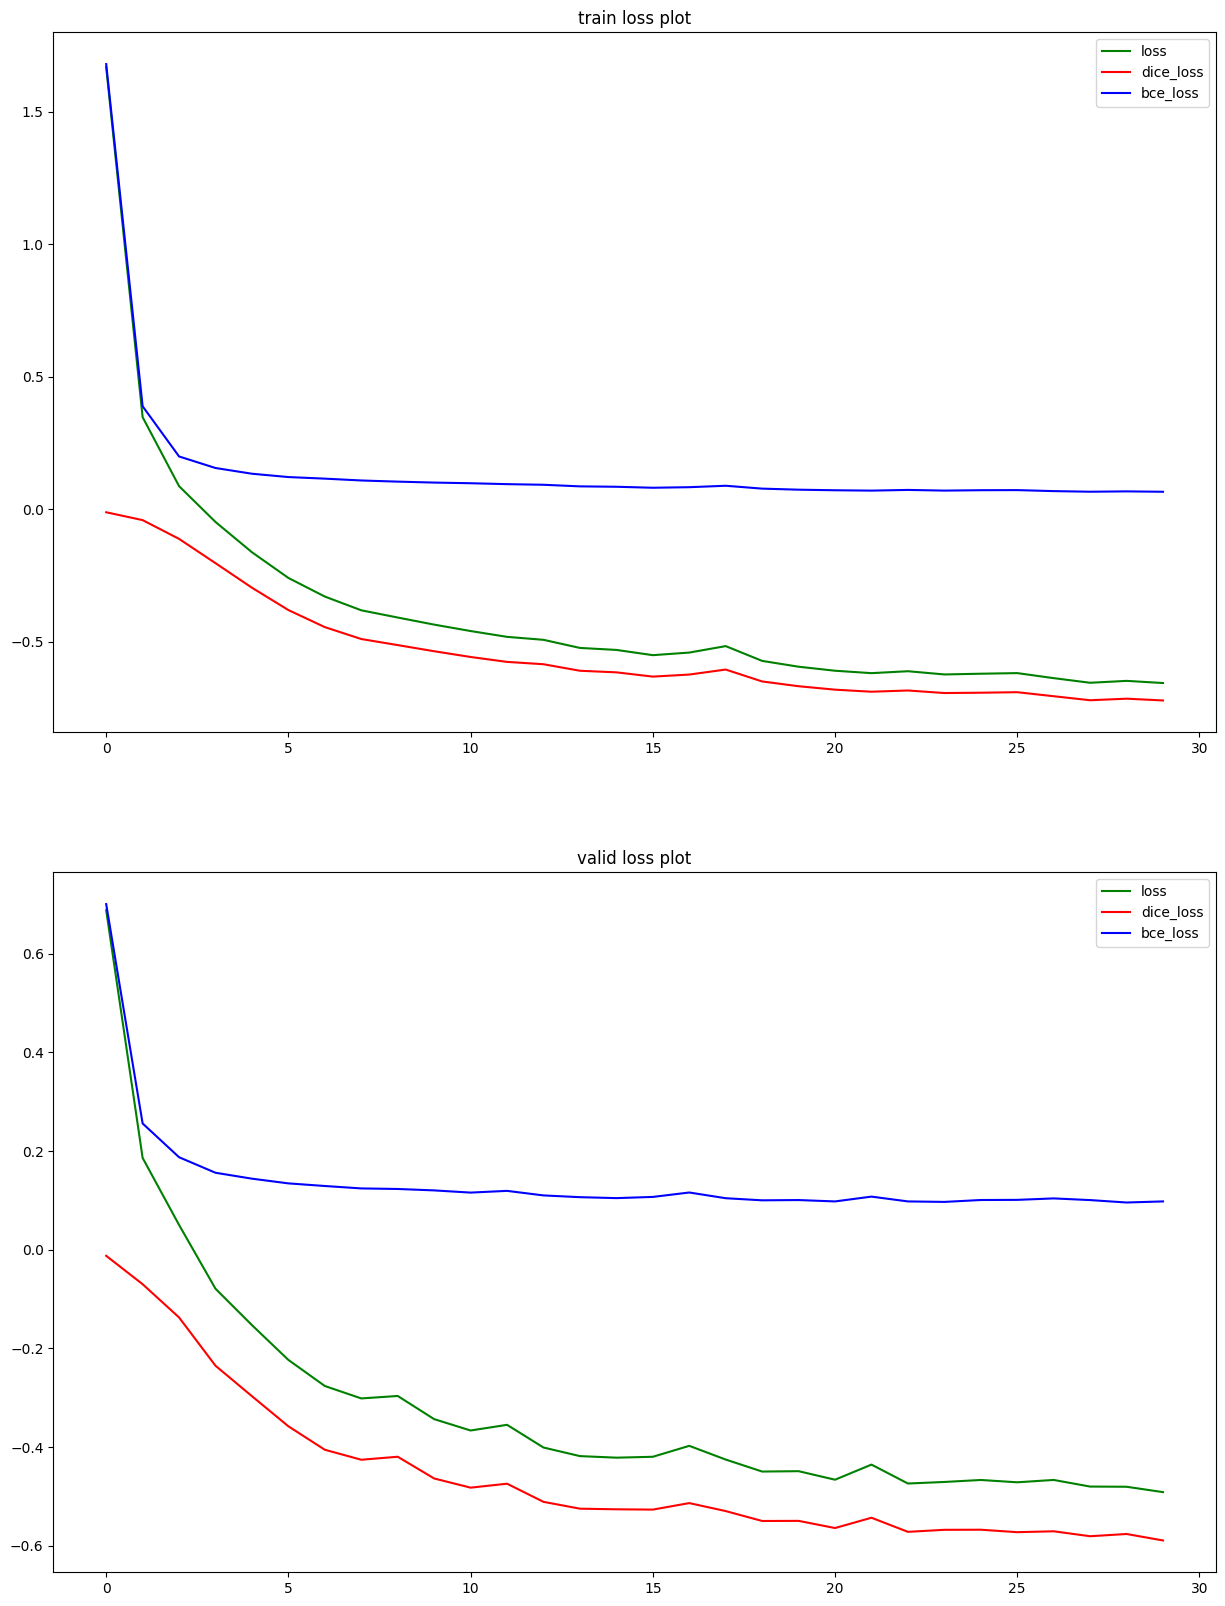

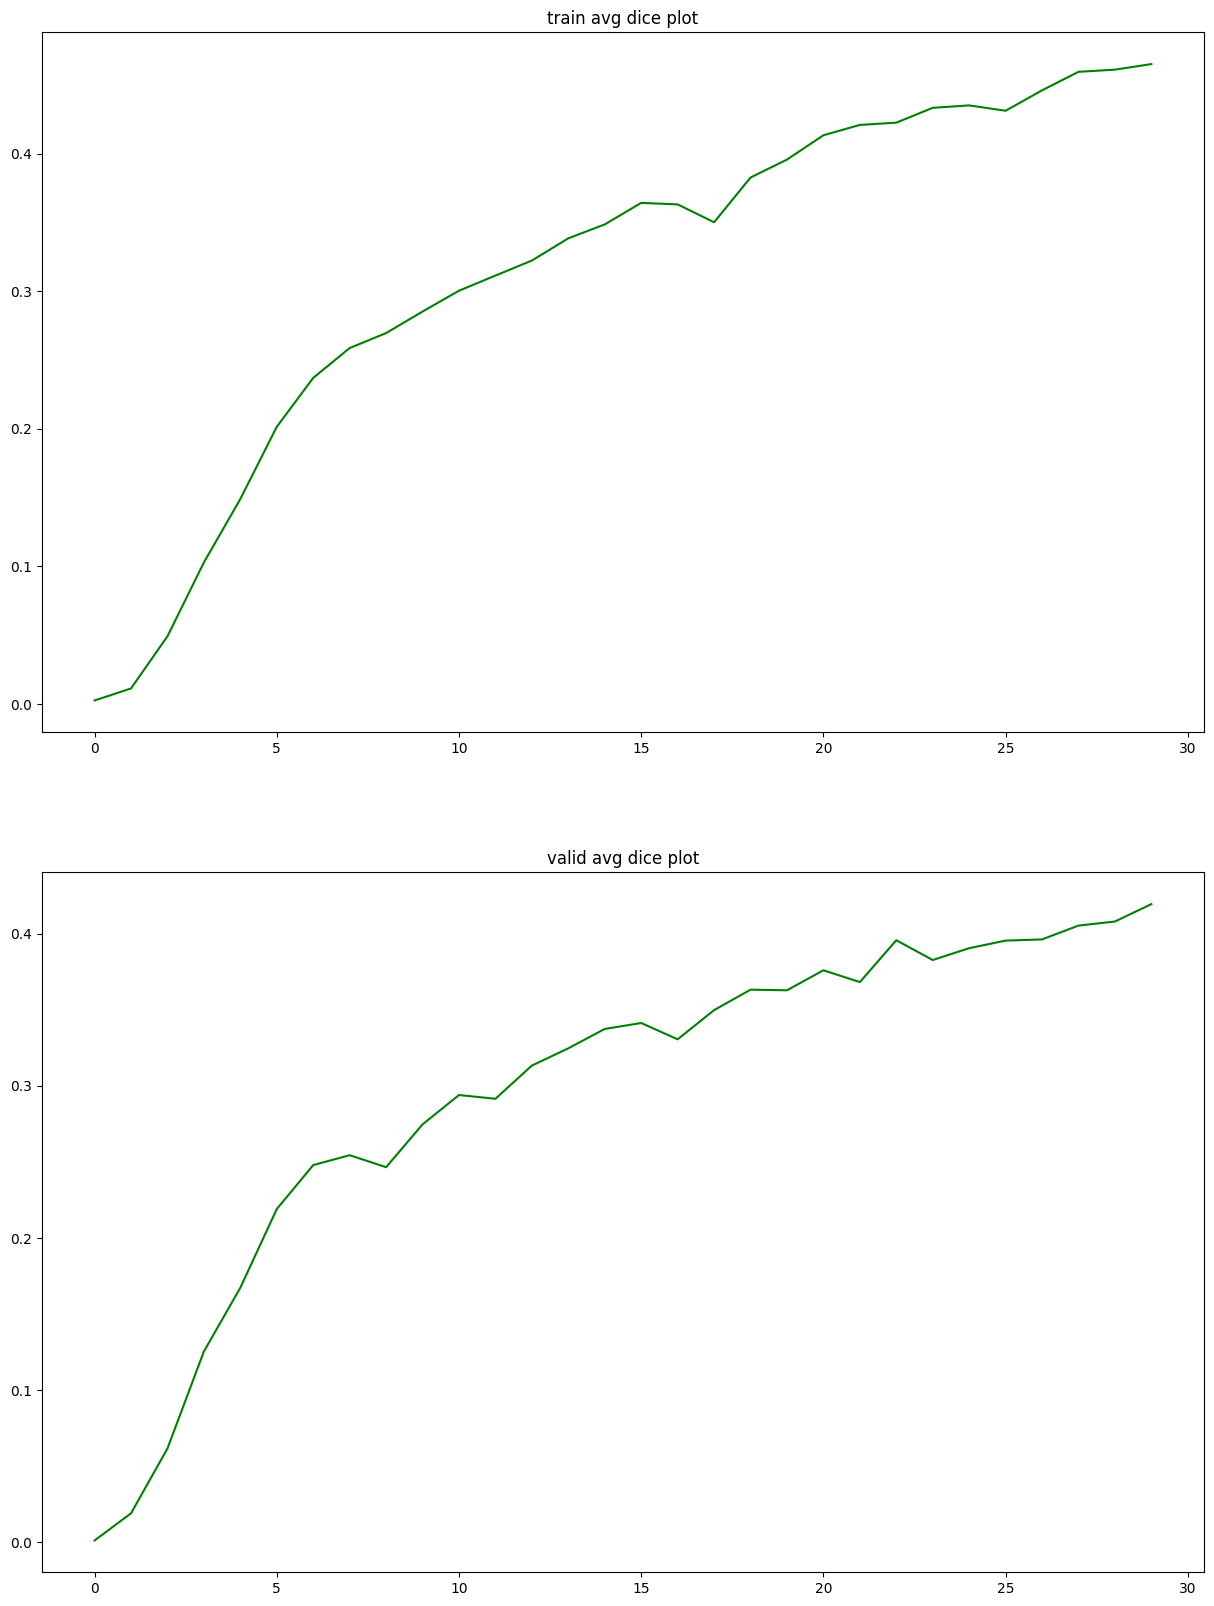

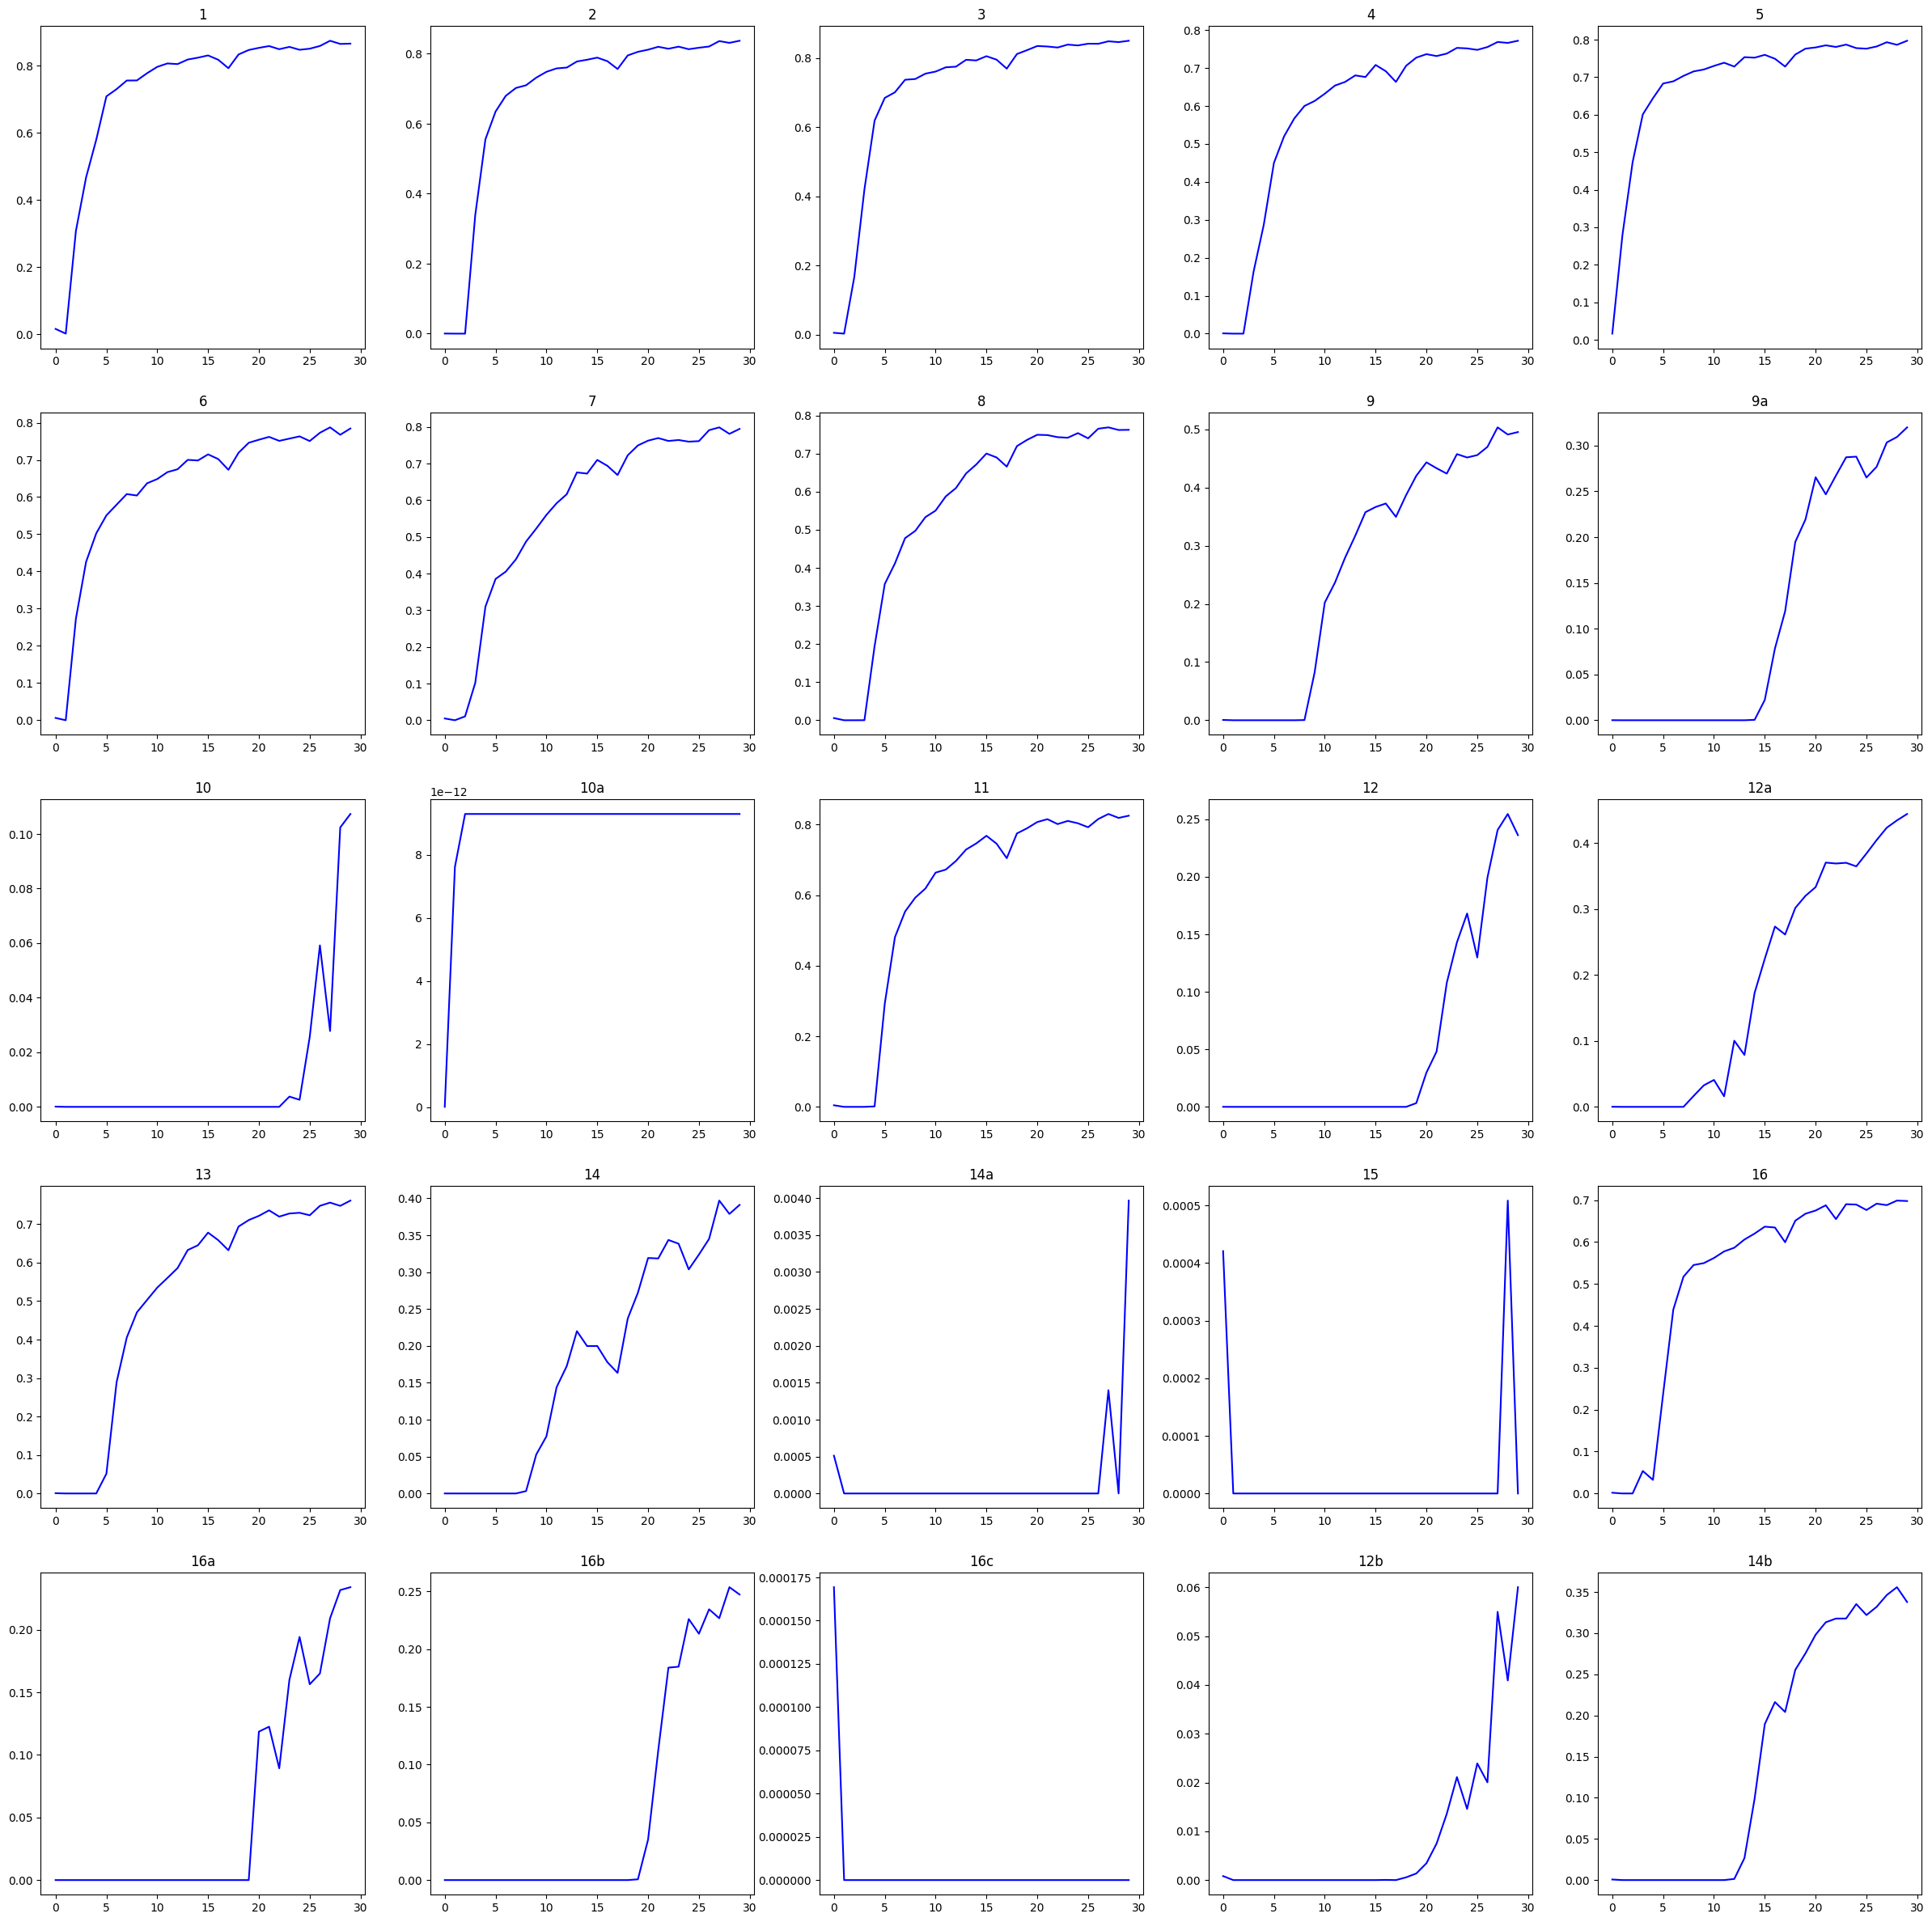

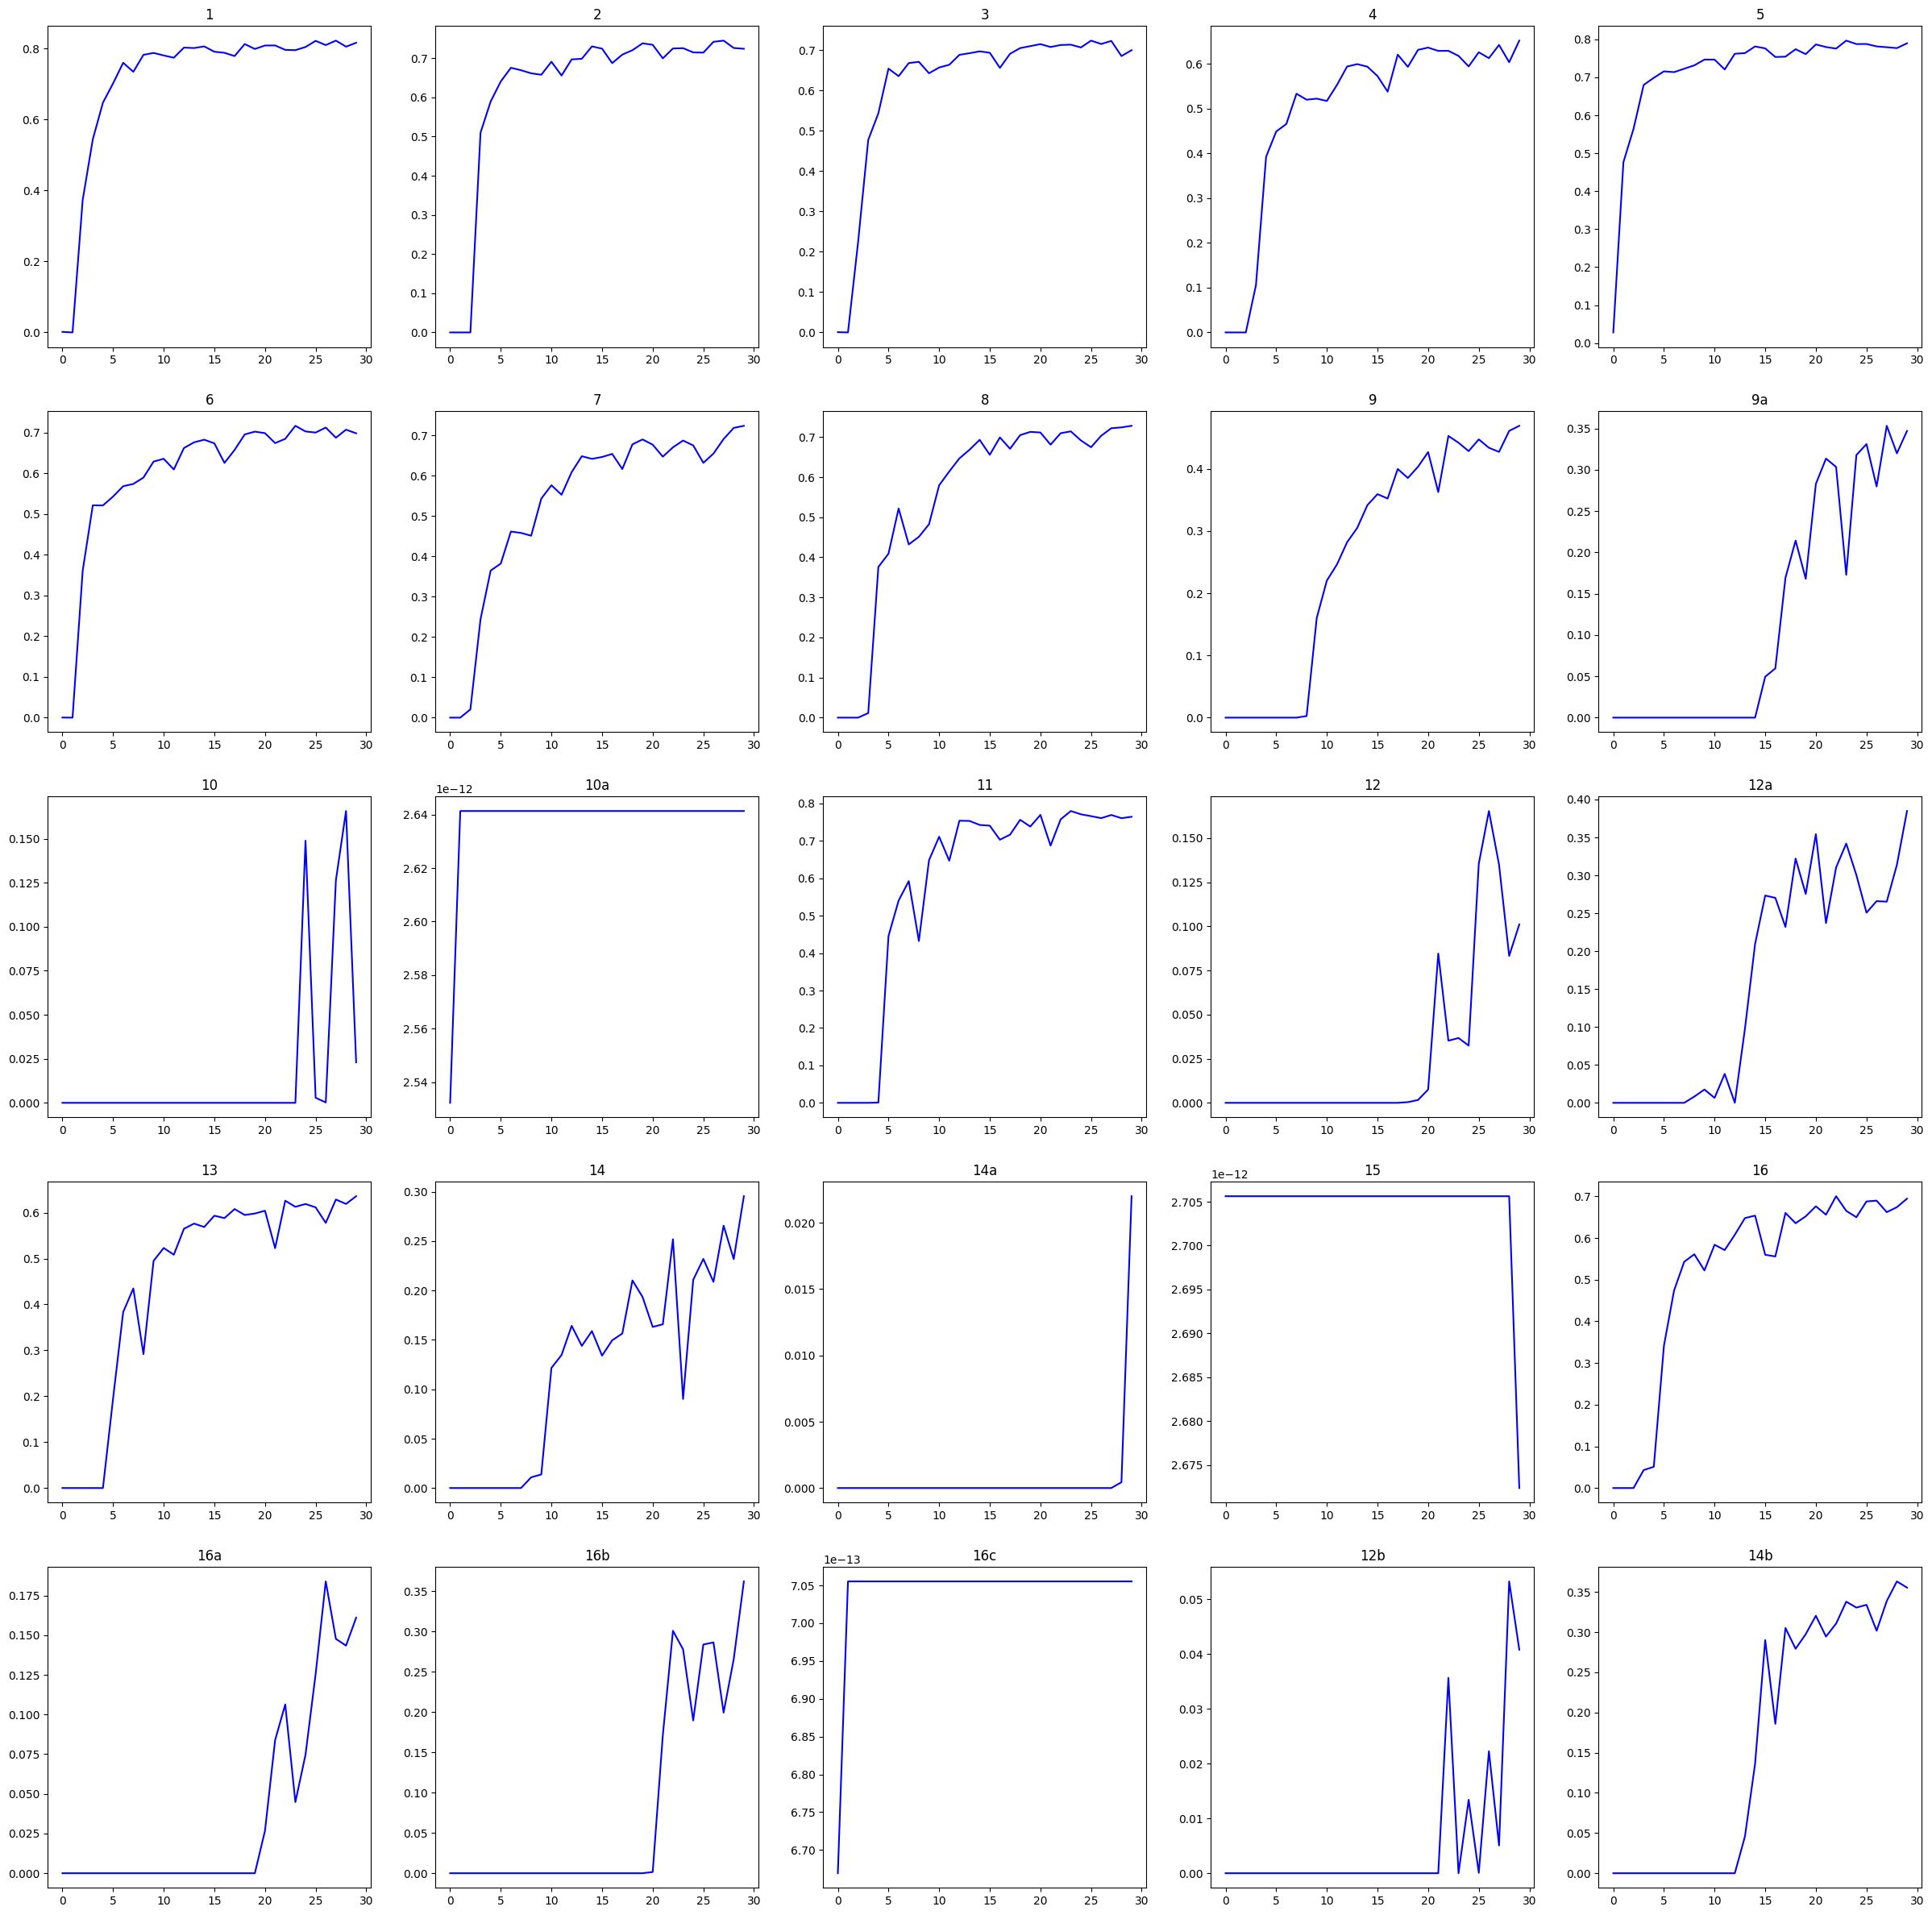

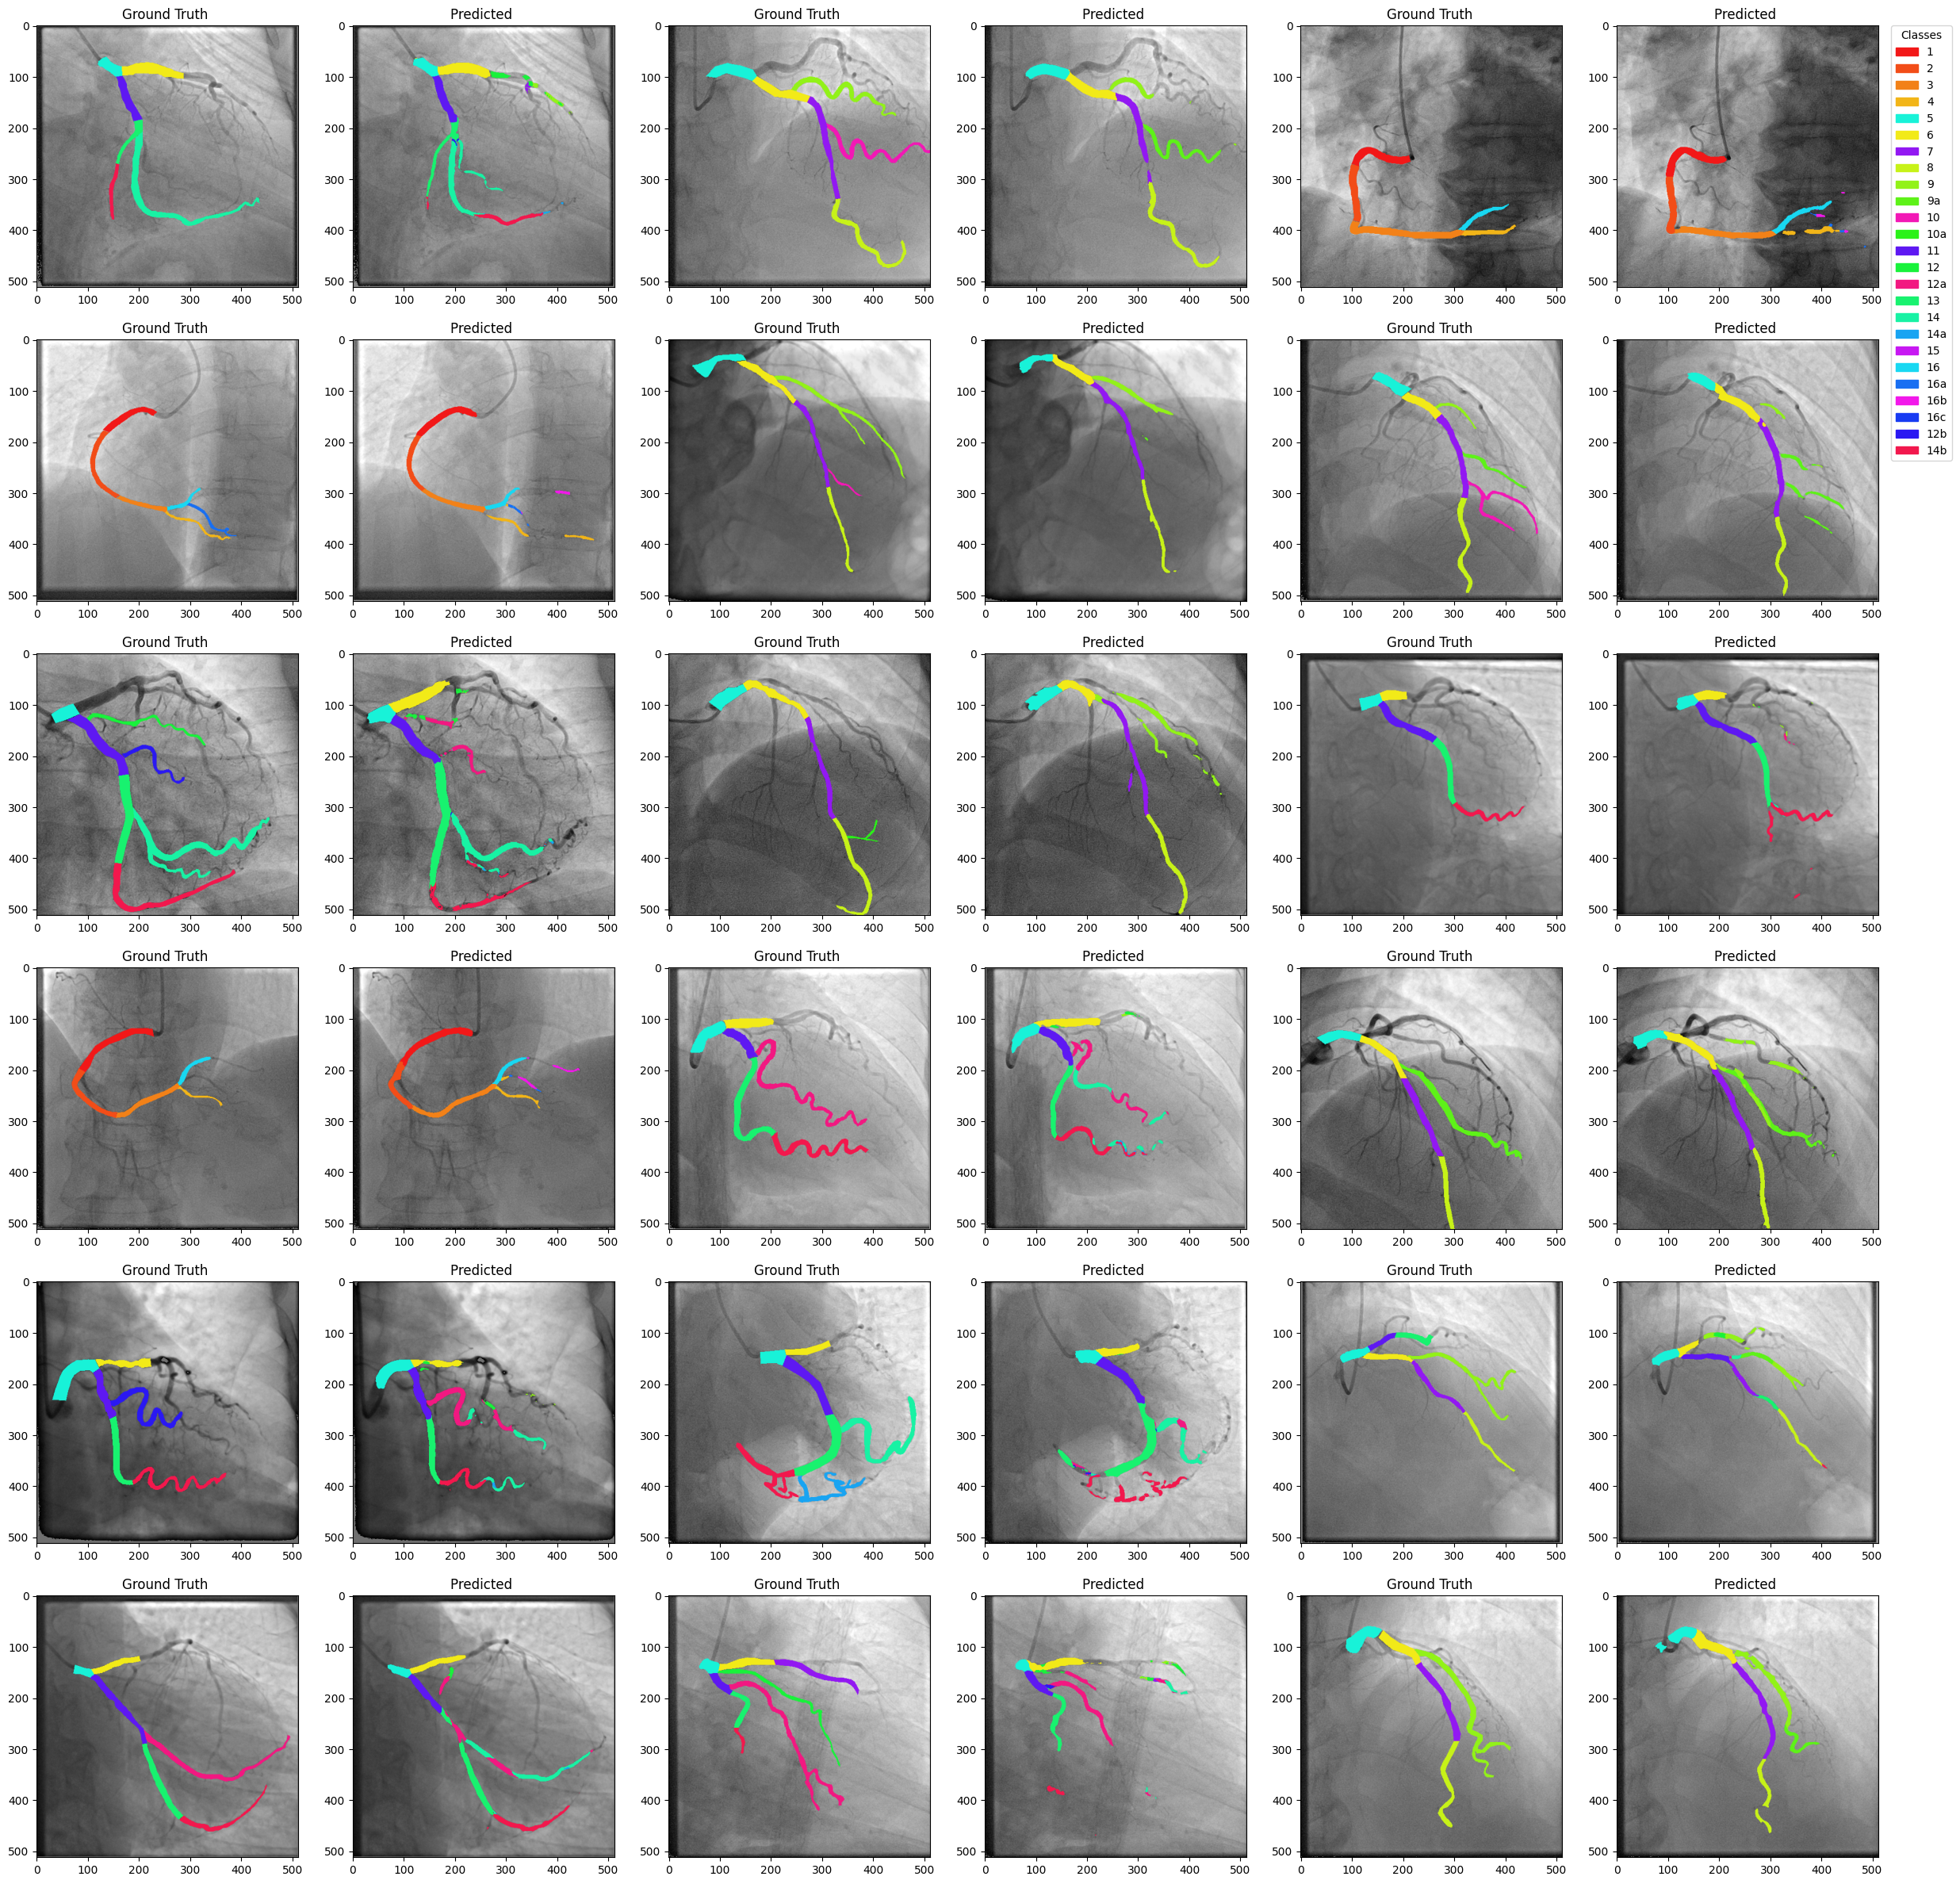

In [5]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)